# TER EDA

In [1]:
# built-in imports
import sys
import os
# src imports
module_path = os.path.abspath(os.path.join('..', '..')) 
sys.path.insert(0, module_path)
from src.utils import load_emorynlp, load_isear, filter_emotions, load_iemocap
# third-party imports 
import numpy as np
import pandas as pd

# load datasets
emory = filter_emotions(load_emorynlp())
isear = filter_emotions(load_isear())

# add a dataset column to each dataset
emory['dataset'] = 'emorynlp'
isear['dataset'] = 'isear'

/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 77 episodes from EmoryNLP train dataset
Loaded 7102 samples from ISEAR dataset


In [4]:
isear.label.value_counts()

label
fear     2252
angry    1701
happy    1616
sad      1533
Name: count, dtype: int64

In [5]:
emory.label.value_counts()

label
neutral    3034
happy      2184
fear       1285
sad         671
Name: count, dtype: int64

In [6]:
#!pip install wordcloud

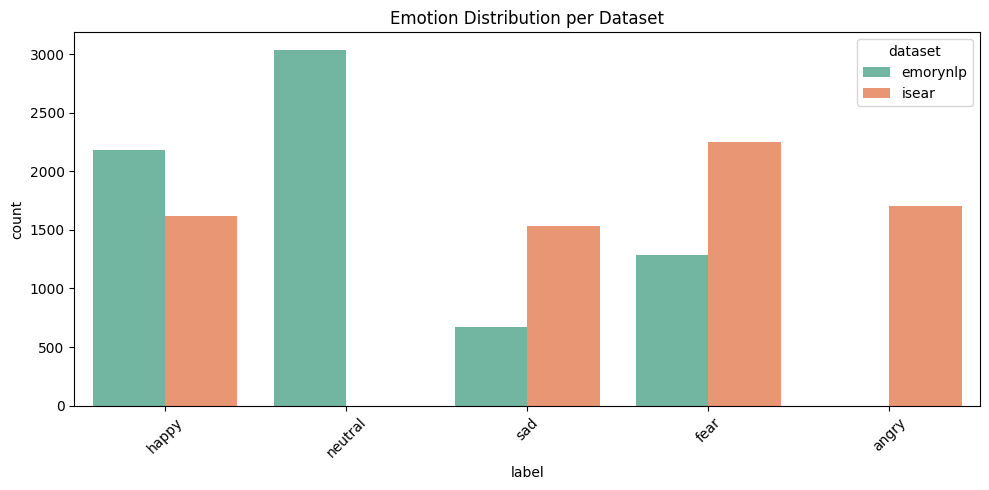

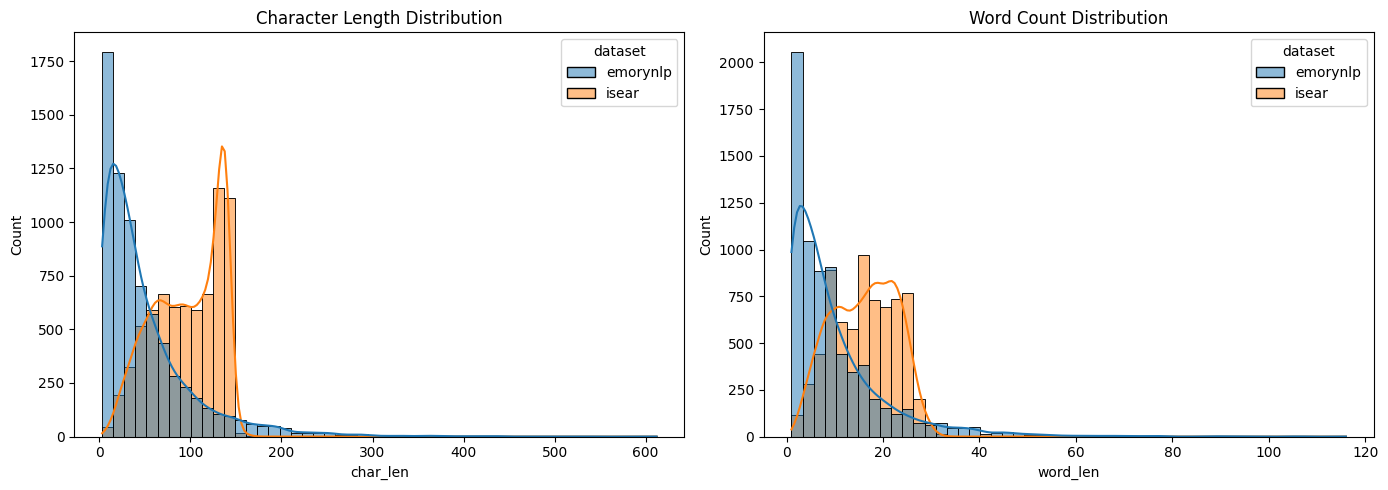

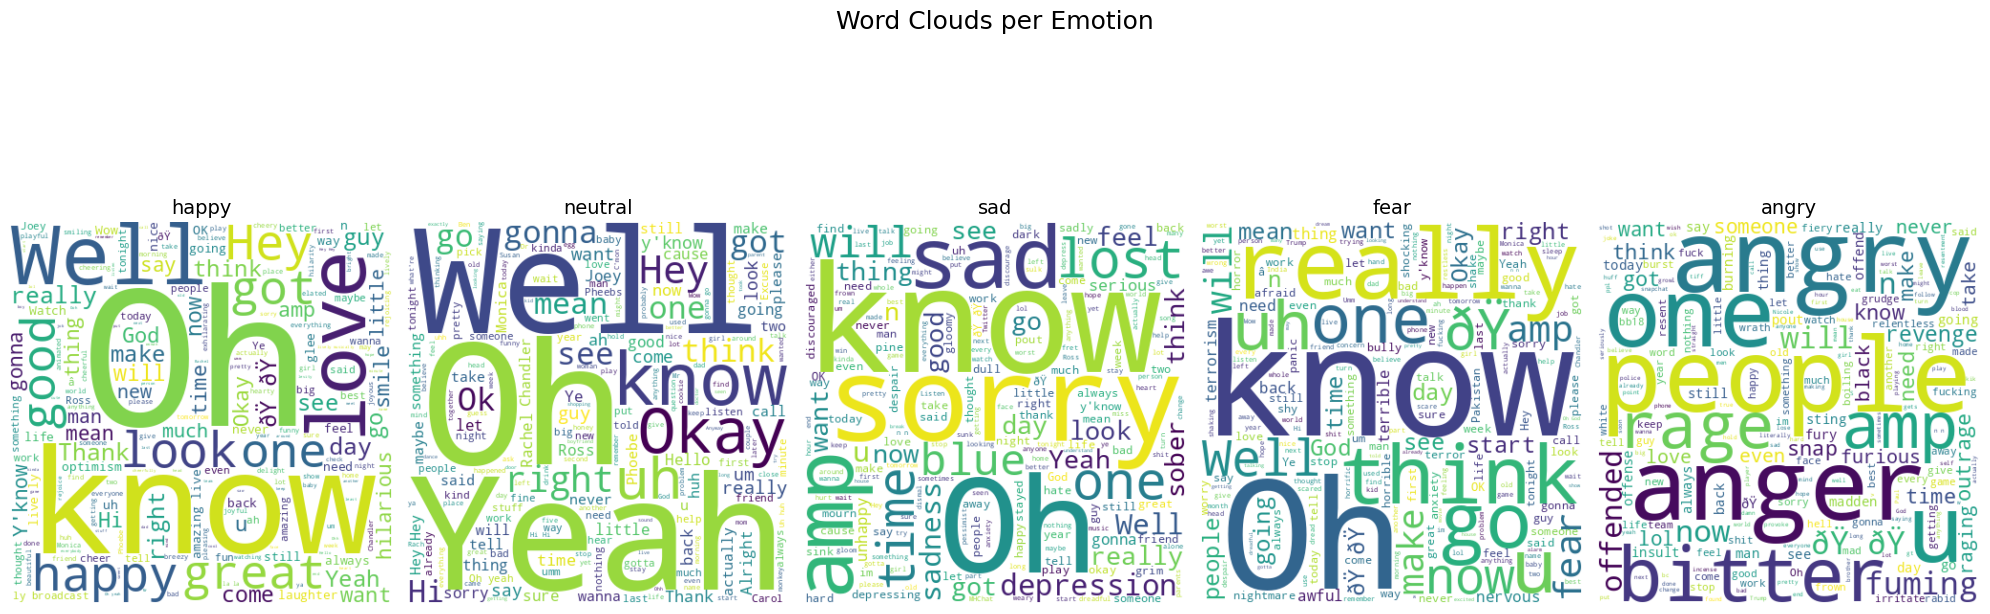

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Combine for joint analysis
df = pd.concat([emory, isear], ignore_index=True)

# ------------------------------------------------
# 1. Label distribution
# ------------------------------------------------
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="label", hue="dataset", palette="Set2")
plt.title("Emotion Distribution per Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 2. Text length analysis
# ------------------------------------------------
df["char_len"] = df["text"].apply(len)
df["word_len"] = df["text"].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(data=df, x="char_len", hue="dataset", bins=50, kde=True, ax=axes[0])
axes[0].set_title("Character Length Distribution")

sns.histplot(data=df, x="word_len", hue="dataset", bins=50, kde=True, ax=axes[1])
axes[1].set_title("Word Count Distribution")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 3. Word clouds per emotion
# ------------------------------------------------
emotions = df["label"].unique()
fig, axes = plt.subplots(1, len(emotions), figsize=(20,8))

for i, emotion in enumerate(emotions):
    text_data = " ".join(df[df["label"] == emotion]["text"])
    wc = WordCloud(width=400, height=400, background_color="white").generate(text_data)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(emotion, fontsize=14)
    axes[i].axis("off")

plt.suptitle("Word Clouds per Emotion", fontsize=18)
plt.tight_layout()
plt.show()



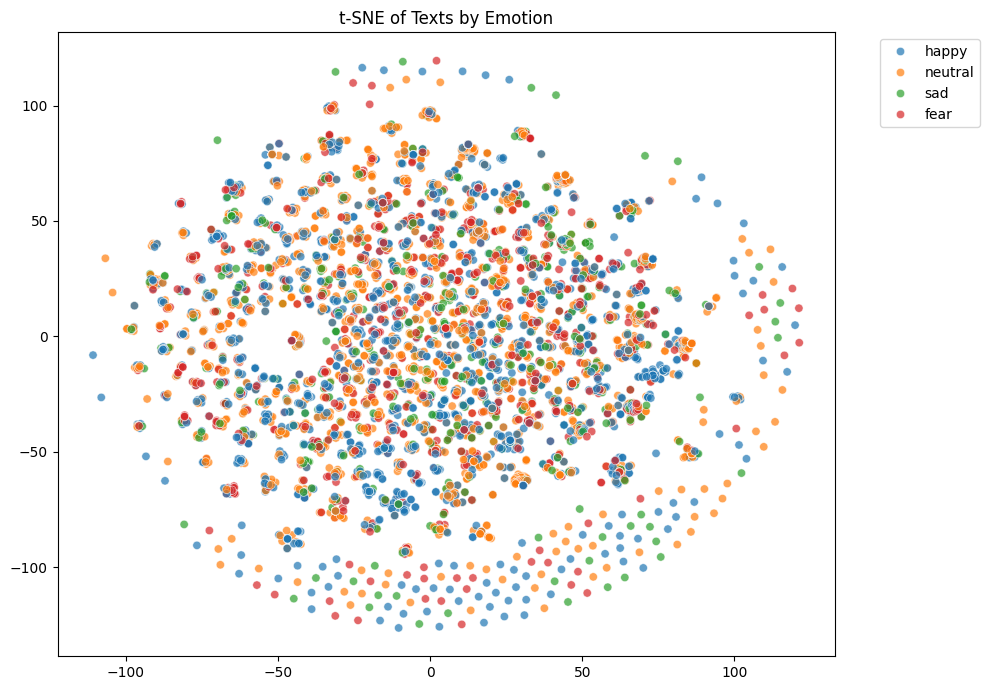

In [16]:
# ------------------------------------------------
# 4. t-SNE visualization (with TF-IDF embeddings)
# ------------------------------------------------
df1,df2 = emory, isear
# Vectorize text
vectorizer = TfidfVectorizer(max_features=300, stop_words="english")
X = vectorizer.fit_transform(df["text"])

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df["label"])

# Run t-SNE (can take a few mins for large data)
tsne = TSNE(n_components=2, random_state=42, perplexity=15, learning_rate="auto")
X_embedded = tsne.fit_transform(X.toarray())

# Plot
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=df["label"], palette="tab10", alpha=0.7)
plt.title("t-SNE of Texts by Emotion")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

/var/folders/0s/lm29041s6hv5pq_lc3jblq540000gn/T/ipykernel_46830/3512714448.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(similarities.keys()), y=list(similarities.values()), palette="viridis")


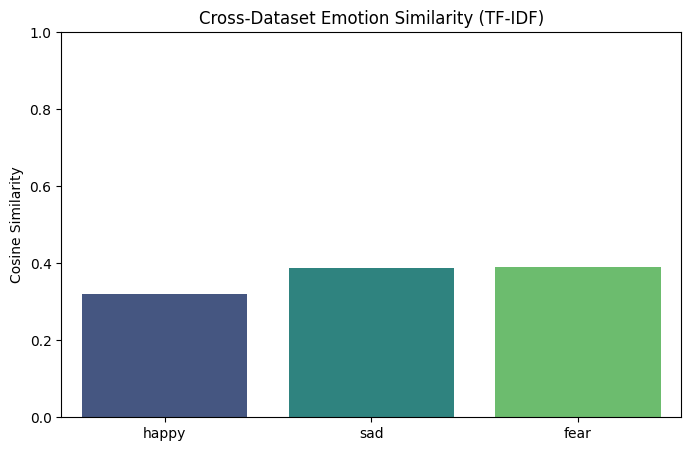

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# ------------------------------------------------
# 5. Cross-dataset similarity per emotion
# ------------------------------------------------

vectorizer = TfidfVectorizer(max_features=300, stop_words="english") #3000

similarities = {}

df1 = emory
df2 = isear

for emotion in df["label"].unique():
    texts1 = df1[df1["label"] == emotion]["text"].tolist()
    texts2 = df2[df2["label"] == emotion]["text"].tolist()

    if len(texts1) > 0 and len(texts2) > 0:
        # Combine for consistent vectorization
        combined = texts1 + texts2
        X = vectorizer.fit_transform(combined)

        # Split back into dataset parts
        X1 = X[:len(texts1)]
        X2 = X[len(texts1):]

        # Compute average embeddings per dataset
        mean1 = np.asarray(X1.mean(axis=0))
        mean2 = np.asarray(X2.mean(axis=0))

        # Cosine similarity
        sim = cosine_similarity(mean1, mean2)[0,0]
        similarities[emotion] = sim

# Plot similarities
plt.figure(figsize=(8,5))
sns.barplot(x=list(similarities.keys()), y=list(similarities.values()), palette="viridis")
plt.ylim(0,1)
plt.ylabel("Cosine Similarity")
plt.title("Cross-Dataset Emotion Similarity (TF-IDF)")
plt.show()


## TESS dataset

In [ ]:
from src.utils import filter_emotions, load_tess
from src.processor import FileProcessor
from tqdm import tqdm
tqdm.pandas()

processor = FileProcessor()
tess = filter_emotions(load_tess())
tess['text'] = tess['filename'].progress_apply(lambda x: processor.process_file(x)['text'])
tess

Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1
['TESS']
['YAF_disgust', 'OAF_Pleasant_surprise', 'OAF_happy', 'YAF_sad', 'TESS Toronto emotional speech set data', 'YAF_happy', 'YAF_neutral', 'OAF_Fear', 'OAF_angry', 'YAF_pleasant_surprised', 'YAF_fear', 'OAF_neutral', 'OAF_disgust', 'YAF_angry', 'OAF_Sad']


  0%|          | 9/2800 [00:22<1:55:29,  2.48s/it]


KeyboardInterrupt: 

: 

In [4]:
processor.process_file(tess.iloc[0].filename)

{'text': ' Say the word date.',
 'segments': [{'id': 0,
   'seek': 0,
   'start': 0.0,
   'end': 2.32,
   'text': ' Say the word date.',
   'tokens': [50364, 6463, 264, 1349, 4002, 13, 50480],
   'temperature': 0.0,
   'avg_logprob': -0.5387323498725891,
   'compression_ratio': 0.6923076923076923,
   'no_speech_prob': 0.018493182957172394}],
 'audio': {'raw': array([ 9.6271979e-05,  1.4950009e-04, -1.9881263e-05, ...,
          4.9534447e-05,  1.0687370e-04,  0.0000000e+00], dtype=float32),
  'audio_chunks': [array([ 9.6271979e-05,  1.4950009e-04, -1.9881263e-05, ...,
           7.2183623e-04, -3.6298516e-05,  3.0010729e-04], dtype=float32)],
  'sample_rate': 16000}}

In [20]:
!pip install fasttext

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp38-cp38-macosx_10_16_x86_64.whl size=383433 sha256=e4d79e5f60d40b2f6de14d4d86ec5073f519100858702a1d4c5610f39575c3e4
  Stored in directory: /Users/sofiafernandes/Library/Caches/pip/wheels/7b/ab/44/06c2149a045ffb2a91d61aaea452674d2e70f00d51de699414
Successfully built fasttext


In [15]:
import fasttext.util
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# Load pretrained FastText (English)
# ------------------------------------------------
fasttext.util.download_model('en', if_exists='ignore')  # downloads cc.en.300.bin
ft = fasttext.load_model('cc.en.300.bin')

def sentence_embedding(text, model):
    """Compute average FastText embedding for a sentence."""
    words = text.split()
    if not words:
        return np.zeros(model.get_dimension())
    vectors = [model.get_word_vector(w) for w in words]
    return np.mean(vectors, axis=0)

# ------------------------------------------------
# 5. Cross-dataset similarity per emotion (FastText)
# ------------------------------------------------
similarities = {}

for emotion in df["label"].unique():
    texts1 = df1[df1["label"] == emotion]["text"].tolist()
    texts2 = df2[df2["label"] == emotion]["text"].tolist()

    if len(texts1) > 0 and len(texts2) > 0:
        # Average embedding per dataset
        emb1 = np.mean([sentence_embedding(t, ft) for t in texts1], axis=0)
        emb2 = np.mean([sentence_embedding(t, ft) for t in texts2], axis=0)

        # Cosine similarity
        sim = cosine_similarity([emb1], [emb2])[0,0]
        similarities[emotion] = sim

# Plot similarities
plt.figure(figsize=(8,5))
sns.barplot(x=list(similarities.keys()), y=list(similarities.values()), palette="viridis")
plt.ylim(0,1)
plt.ylabel("Cosine Similarity")
plt.title("Cross-Dataset Emotion Similarity (FastText)")
plt.show()


NameError: name 'df1' is not defined

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# Load pretrained GloVe
# ------------------------------------------------
def load_glove_embeddings(glove_path="glove.6B.300d.txt"):
    embeddings = {}
    with open(glove_path, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

glove = load_glove_embeddings("glove.6B.300d.txt")  # make sure you download it first
dim = 300

def sentence_embedding_glove(text, embeddings, dim=300):
    words = text.split()
    vectors = [embeddings[w] for w in words if w in embeddings]
    if not vectors:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

# ------------------------------------------------
# Cross-dataset similarity per emotion (GloVe)
# ------------------------------------------------
similarities = {}

for emotion in df["label"].unique():
    texts1 = df1[df1["label"] == emotion]["text"].tolist()
    texts2 = df2[df2["label"] == emotion]["text"].tolist()

    if len(texts1) > 0 and len(texts2) > 0:
        # Average embedding per dataset
        emb1 = np.mean([sentence_embedding_glove(t, glove, dim) for t in texts1], axis=0)
        emb2 = np.mean([sentence_embedding_glove(t, glove, dim) for t in texts2], axis=0)

        # Cosine similarity
        sim = cosine_similarity([emb1], [emb2])[0,0]
        similarities[emotion] = sim

# Plot similarities
plt.figure(figsize=(8,5))
sns.barplot(x=list(similarities.keys()), y=list(similarities.values()), palette="mako")
plt.ylim(0,1)
plt.ylabel("Cosine Similarity")
plt.title("Cross-Dataset Emotion Similarity (GloVe)")
plt.show()
